#### Import các thư viện cần thiết

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

#### Xác định phần cứng và cố định tham số ngẫu nhiên

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benckmark = False

SEED = 42
set_seed(SEED)

#### Tải bộ dữ liệu

In [4]:
train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data', 
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

#### Chia bộ dữ liệu train/val/test

In [5]:
train_ratio = 0.9
batch_size = 128
train_size = int(len(train_dataset) * train_ratio) 
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train size: {len(train_subset)}')
print(f'Validation size: {len(val_subset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 54000
Validation size: 6000
Test size: 10000


### Weight increasing with std=1.0

#### Xây dựng mô hình MLP

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out
    
input_dims = 784 # (28, 28)
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

#### Huấn luyện mô hình

In [7]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)
    
    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
        count += len(y_val)
    
    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.1463, Train_Acc: 0.3689, Validation Loss: 1.4836, Val_Acc: 0.4880
EPOCH 2/100, Train_Loss: 1.3220, Train_Acc: 0.5321, Validation Loss: 1.2625, Val_Acc: 0.5505
EPOCH 3/100, Train_Loss: 1.1642, Train_Acc: 0.5856, Validation Loss: 1.1484, Val_Acc: 0.5933
EPOCH 4/100, Train_Loss: 1.0714, Train_Acc: 0.6156, Validation Loss: 1.0710, Val_Acc: 0.6163
EPOCH 5/100, Train_Loss: 1.0066, Train_Acc: 0.6389, Validation Loss: 1.0162, Val_Acc: 0.6318
EPOCH 6/100, Train_Loss: 0.9592, Train_Acc: 0.6545, Validation Loss: 0.9725, Val_Acc: 0.6525
EPOCH 7/100, Train_Loss: 0.9216, Train_Acc: 0.6671, Validation Loss: 0.9408, Val_Acc: 0.6598
EPOCH 8/100, Train_Loss: 0.8916, Train_Acc: 0.6772, Validation Loss: 0.9148, Val_Acc: 0.6690
EPOCH 9/100, Train_Loss: 0.8664, Train_Acc: 0.6860, Validation Loss: 0.8917, Val_Acc: 0.6790
EPOCH 10/100, Train_Loss: 0.8453, Train_Acc: 0.6944, Validation Loss: 0.8731, Val_Acc: 0.6863
EPOCH 11/100, Train_Loss: 0.8271, Train_Acc: 0.7001, Validation Loss:

#### Trực quan hóa

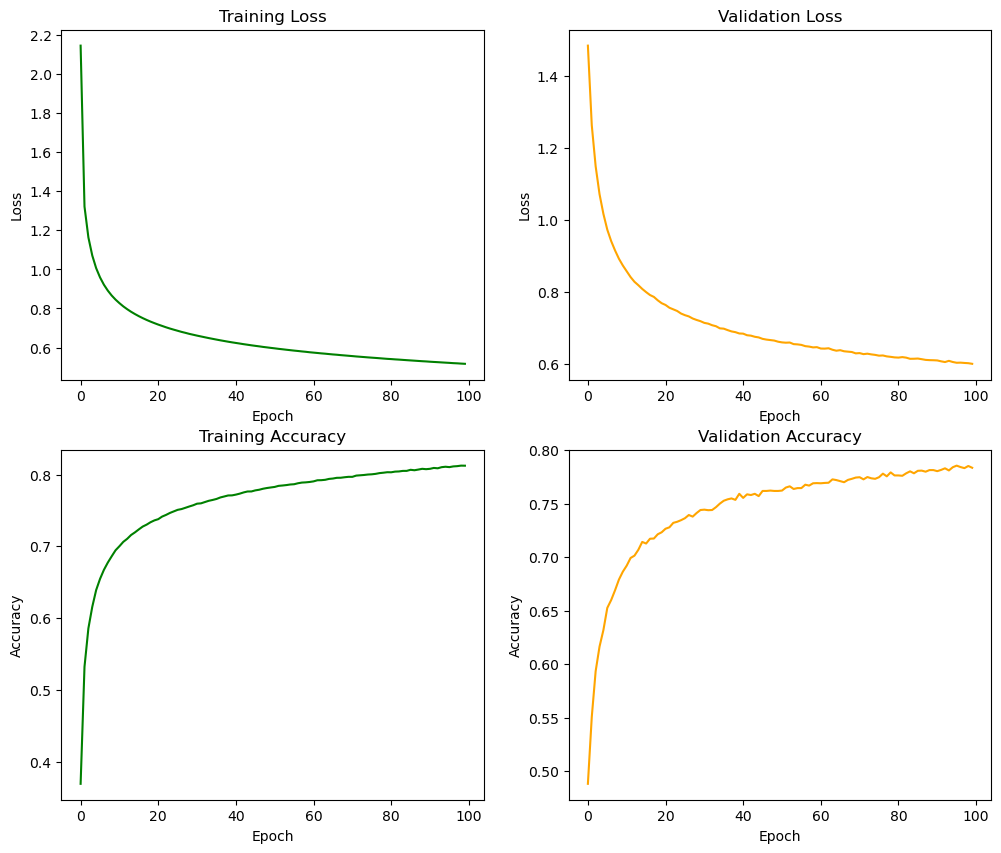

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

#### Đánh giá mô hình

In [10]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader: 
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.7817


### Weight increasing with std=10.0

#### Xây dựng mô hình MLP

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=10.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out
    
input_dims = 784 # (28, 28)
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

#### Huấn luyện mô hình

In [12]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)
    
    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
        count += len(y_val)
    
    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 85.2663, Train_Acc: 0.0975, Validation Loss: 36.4312, Val_Acc: 0.0635
EPOCH 2/100, Train_Loss: 16.4388, Train_Acc: 0.1014, Validation Loss: 5.6015, Val_Acc: 0.1032
EPOCH 3/100, Train_Loss: 3.9975, Train_Acc: 0.1016, Validation Loss: 3.9933, Val_Acc: 0.1075
EPOCH 4/100, Train_Loss: 3.5564, Train_Acc: 0.1058, Validation Loss: 3.1377, Val_Acc: 0.1068
EPOCH 5/100, Train_Loss: 2.9314, Train_Acc: 0.1015, Validation Loss: 2.7407, Val_Acc: 0.0842
EPOCH 6/100, Train_Loss: 2.6703, Train_Acc: 0.1024, Validation Loss: 2.6632, Val_Acc: 0.0812
EPOCH 7/100, Train_Loss: 2.5633, Train_Acc: 0.1052, Validation Loss: 2.5083, Val_Acc: 0.0865
EPOCH 8/100, Train_Loss: 2.5588, Train_Acc: 0.1061, Validation Loss: 2.5985, Val_Acc: 0.0853
EPOCH 9/100, Train_Loss: 2.5282, Train_Acc: 0.1053, Validation Loss: 2.5429, Val_Acc: 0.1163
EPOCH 10/100, Train_Loss: 2.5210, Train_Acc: 0.1038, Validation Loss: 2.5196, Val_Acc: 0.1050
EPOCH 11/100, Train_Loss: 2.4801, Train_Acc: 0.1054, Validation Lo

#### Trực quan hóa

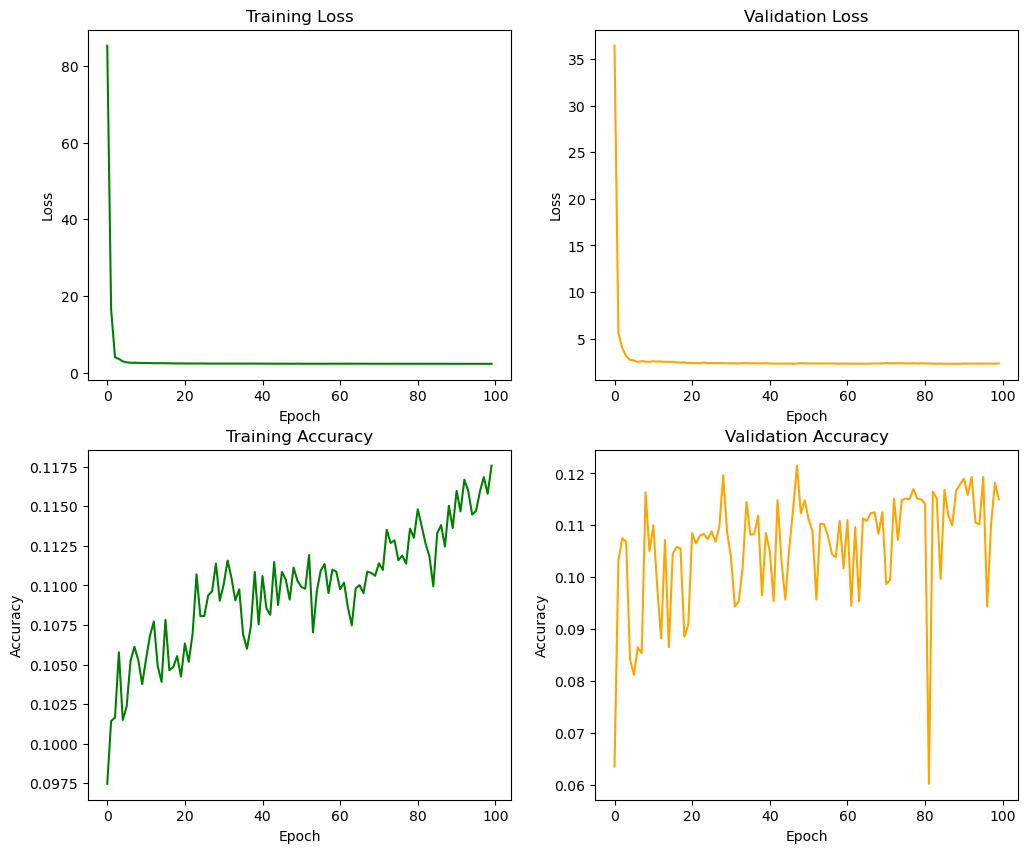

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

#### Đánh giá mô hình

In [14]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader: 
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.1145
